In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

from iqradre.detect.pred import BoxesPredictor

from iqradre.recog.prod import TextPredictor
from iqradre.recog.prod import utils as text_utils

import transformers
from transformers import BertTokenizer
from iqradre.extract.prod.prod import Extractor

import matplotlib.pyplot as plt
from iqradre.detect.ops import boxes as boxes_ops
from iqradre.detect.ops import box_ops

In [3]:
transformers.__version__

'3.5.0'

In [4]:
craft_weight = f'../weights/detect/craft_ktp_ohem.pth.tar'
crnn_path = '../weights/recog/ocrnet_pretrained_ktp.pth'
layoutlm_path = '../weights/extract/layoutlm_v2.pth'

In [5]:
predictor = BoxesPredictor(weight_path=craft_weight, device='cpu')
text_pred = TextPredictor(weight_path=crnn_path)
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
extract = Extractor(tokenizer=tokenizer, weight=layoutlm_path)

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

In [58]:
%%time
impath = 'images/test1.png'
# impath = transform.do_autocrop_deskew(impath)
result = predictor.predict_word_boxes(impath, text_threshold=0.3, low_text=0.2)
polys, boxes, images_patch, img, score_text, score_link, ret_score_text = result

CPU times: user 497 ms, sys: 36.3 ms, total: 533 ms
Wall time: 248 ms


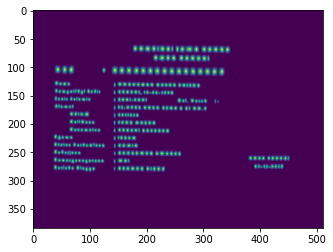

In [59]:
plt.imshow(score_text)

In [60]:
boxes_list = box_ops.batch_box_coordinate_to_xyminmax(boxes, to_int=True).tolist()   
boxes_list[0]

[350.0, 119.0, 499.0, 153.0]

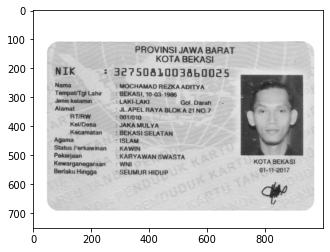

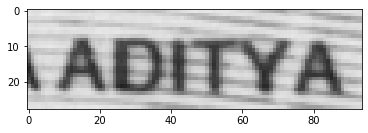

[508.0, 251.0, 591.0, 276.0]


In [61]:
idx = 12
plt.imshow(img);plt.show()
plt.imshow(images_patch[idx]);plt.show()
print(boxes_list[idx])

In [62]:
%%time
text_list = text_pred.predict(images_patch)

CPU times: user 6.37 s, sys: 6.63 ms, total: 6.38 s
Wall time: 817 ms


In [63]:
text_list

['PROVINSI,',
 'JAWA',
 'BARAT',
 'KOTA',
 'BEKASI',
 'NIK',
 '3275081003860025',
 'I/',
 'Nama',
 'MOCHAMAD',
 'E-',
 'REZKA',
 'ADITYA',
 'Tempat/Tgl',
 'Lahir',
 'BEKASI,',
 '10-03-1986',
 'LA',
 'Jenis',
 'kelamin',
 'LAKI-LAKI',
 'S.',
 'Gol/ang',
 'Darah',
 'S',
 'Alamat',
 'JL.APEL',
 'a',
 'RAYA',
 'BLOK',
 'A-',
 '21K',
 'NO',
 'at',
 'RT/RW',
 '001/010',
 'S.',
 'Kel/Desa',
 'JAKA',
 'L.',
 'MULYA',
 'Kecamatan',
 'BEKASI',
 'ISELATAN',
 'L.',
 'Agama',
 'ISLAM',
 'R.',
 'Status',
 'Perkawinan',
 'KAWIN',
 'SADATAN',
 'Pekerjaan',
 'KARYAWAN',
 'Sa',
 'ISWASTA',
 'KOTAI',
 'BEKASI',
 'Kewarganegaraan',
 'WNI',
 'Sendartan',
 '01-11-2017',
 'Berlaku',
 'Hingga',
 'SEUMUR',
 'HIDUP',
 '-']

In [64]:
data_annoset = text_utils.build_annoset(text_list, boxes)
data_annoset = sorted(data_annoset, key = lambda i: (i['bbox'][1], i['bbox'][0]))

In [65]:
data, clean = extract.predict(data_annoset)

In [66]:
data

{'provinsi': 'JAWA BARAT',
 'kabupaten': 'KOTA BEKASI',
 'nik': '3275081003860025',
 'nama': 'I/ E- MOCHAMAD REZKA ADITYA',
 'ttl': 'BEKASI, 10-03-1986',
 'gender': 'LAKI-LAKI',
 'goldar': '',
 'alamat': 'JL.APEL RAYA BLOK A- 21K NO at',
 'rtrw': '001/010',
 'kelurahan': 'JAKA MULYA',
 'kecamatan': 'BEKASI ISELATAN ISWASTA',
 'agama': 'ISLAM',
 'perkawinan': 'KAWIN',
 'pekerjaan': 'KARYAWAN',
 'kewarganegaraan': 'WNI',
 'berlaku': 'SEUMUR HIDUP',
 'sign_place': 'KOTAI BEKASI',
 'sign_date': '01-11-2017'}

In [28]:
pd.set_option("max_rows", None)
pd.DataFrame(clean)

,words,bboxes,tokens,labels,gseq,wseq
0,PROVINSI,"[324.0, 10.0, 488.0, 44.0]",provinsi,U-FLD_PROV,0,0
1,JAWA,"[490.0, 10.0, 586.0, 44.0]",jawa,B-VAL_PROV,1,0
2,BARAT,"[590.0, 10.0, 705.0, 49.0]",barat,L-VAL_PROV,2,0
3,KOTA,"[404.0, 44.0, 498.0, 78.0]",kota,U-FLD_KAB,3,0
4,DEPOK,"[504.0, 45.0, 624.0, 79.0]",depok,U-VAL_KAB,4,0
5,3201130111890001,"[246.0, 92.0, 677.0, 134.0]",320,B-VAL_NIK,5,0
6,3201130111890001,"[246.0, 92.0, 677.0, 134.0]",##113,I-VAL_NIK,5,1
7,3201130111890001,"[246.0, 92.0, 677.0, 134.0]",##01,I-VAL_NIK,5,2
8,3201130111890001,"[246.0, 92.0, 677.0, 134.0]",##118,I-VAL_NIK,5,3
9,3201130111890001,"[246.0, 92.0, 677.0, 134.0]",##9000,I-VAL_NIK,5,4


In [ ]:
trans